## Understanding Neurogym Task

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neurogym/neurogym/blob/master/examples/understanding_neurogym_task.ipynb)

This is a tutorial for understanding Neurogym task structure. Here we will go through

1. Defining a basic OpenAI gym task
2. Defining a basic trial-based neurogym task
3. Adding observation and ground truth in neurogym tasks

### Installation

Only needed if running in Google colab. Uncomment to run.

In [2]:
# # Install gym
# ! pip install gym

# # Install neurogym
# ! git clone https://github.com/gyyang/neurogym.git
# %cd neurogym/
# ! pip install -e .

### OpenAI gym tasks

Neurogym tasks follow basic [OpenAI gym](https://gym.openai.com/) tasks format. Each task is defined as a Python class, inheriting from the ```gym.Env``` class.

In this section we describe basic structure for an OpenAI gym task.

In the ```__init__``` method, it is necessary to define two attributes, ```self.observation_space``` and ```self.action_space``` which describe the kind of spaces used by observations (network inputs) and actions (network outputs).

In [3]:
import warnings
warnings.filterwarnings("ignore")  # to suppress warnings

import numpy as np
import gym

class MyEnv(gym.Env):
    def __init__(self):
        super().__init__()  # Python boilerplate to initialize base class

        # A two-dimensional box with minimum and maximum value set by low and high
        self.observation_space = gym.spaces.Box(low=0., high=1., shape=(2,))
        
        # A discrete space with 3 possible values (0, 1, 2)
        self.action_space = gym.spaces.Discrete(3)
        
# Instantiate an environment
env = MyEnv()
print('Sample random observation value')
print(env.observation_space.sample())
print('Sample random action value')
print(env.action_space.sample())

Sample random observation value
[0.880155  0.4379391]
Sample random action value
0


Another key method that needs to be defined is the ```step``` method, which updates the environment and outputs observations and rewards after receiving the agent's action.

The ```step``` method takes ```action``` as inputs, and outputs 
    the agent's next observation ```observation```,
    a scalar reward received by the agent ```reward```,
    a boolean describing whether the environment needs to be reset ```done```, and
    a dictionary holding any additional information ```info```.
    
If the environment is described by internal states, the ```reset``` method would reset these internal states. This method returns an initial observation ```observation```.

In [4]:
class MyEnv(gym.Env):
    def __init__(self):
        super().__init__()  # Python boilerplate to initialize base class
        self.observation_space = gym.spaces.Box(low=-10., high=10., shape=(1,))
        self.action_space = gym.spaces.Discrete(3)
    
    def step(self, action):
        ob = self.observation_space.sample()  # random sampling
        reward = 1.  # reward
        done = False  # never ending
        info = {}  # empty dictionary
        return ob, reward, done, info
    
    def reset(self):
        ob = self.observation_space.sample()
        return ob

Below we define a simple task where actions move an agent along a one-dimensional line. The reward is determined by the agent's location on this line.

Text(0, 0.5, 'Reward')

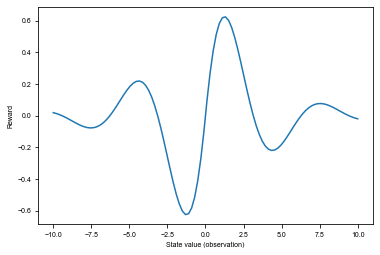

In [5]:
import matplotlib.pyplot as plt

def get_reward(x):
    return np.sin(x) * np.exp(-np.abs(x)/3)

xs = np.linspace(-10, 10, 100)
plt.plot(xs, get_reward(xs))
plt.xlabel('State value (observation)')
plt.ylabel('Reward')

In [6]:
class MyEnv(gym.Env):
    def __init__(self):
        # A one-dimensional box with minimum and maximum value set by low and high
        self.observation_space = gym.spaces.Box(low=-10., high=10., shape=(1,))
        
        # A discrete space with 3 possible values (0, 1, 2)
        self.action_space = gym.spaces.Discrete(3)
    
        self.state = 0.
    
    def step(self, action):
        # Actions 0, 1, 2 correspond to state change of -0.1, 0, +0.1 
        self.state += (action - 1.) * 0.1
        self.state = np.clip(self.state, -10, 10)
        
        ob = self.state  # observation
        reward = get_reward(self.state)  # reward
        done = False  # never ending
        info = {}  # empty dictionary
        return ob, reward, done, info
    
    def reset(self):
        # Re-initialize state
        self.state = self.observation_space.sample()
        return self.state

An agent can interact with the environment iteratively.

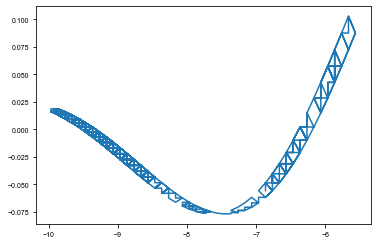

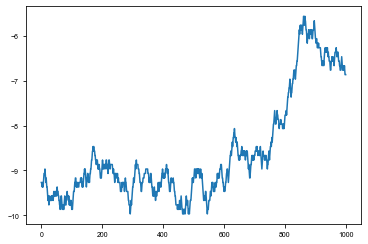

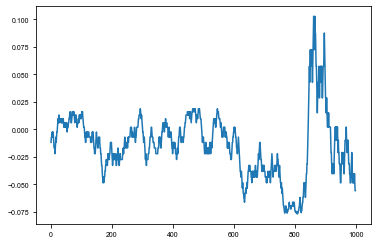

In [7]:
env = MyEnv()
ob = env.reset()
ob_log = list()
reward_log = list()

for i in range(1000):
    action = env.action_space.sample()  # A random agent
    ob, reward, done, info = env.step(action)
    ob_log.append(ob)
    reward_log.append(reward)
    
plt.plot(ob_log, reward_log)
plt.show()
plt.plot(ob_log)
plt.show()
plt.plot(reward_log)
plt.show()

### Trial-based Neurogym Tasks

Many neuroscience and cognitive science tasks have trial structure. ```neurogym.TrialEnv``` provides a class for common trial-based tasks. Its main difference from ```gym.Env``` is the ```_new_trial()``` method that generates abstract information about a new trial, and optionally, the observation and ground-truth output. Additionally, users provide a ```_step()``` method instead of ```step()```.

The ```_new_trial()``` method takes any key-word arguments (```**kwargs```), and outputs a dictionary ```trial``` containing relevant information about this trial. This dictionary is accesible during ```_step``` as ```self.trial```.

Here we define a simple task where the agent needs to make a binary decision on every trial based on its observation. Each trial is only one time step.

In [8]:
# TODO: remove this later
import sys
sys.path.append("..") # import the developing neurogym package

import neurogym as ngym
from neurogym import TrialEnv

class MyTrialEnv(TrialEnv):
    def __init__(self):
        super().__init__()
        self.observation_space = gym.spaces.Box(low=-1., high=1., shape=(1,))
        self.action_space = gym.spaces.Discrete(2)

        self.next_ob = np.random.uniform(-1, 1, size=(1,))

    def _new_trial(self):
        ob = self.next_ob  # observation previously computed
        # Sample observation for the next trial
        self.next_ob = np.random.uniform(-1, 1, size=(1,))
        
        trial = dict()
        # Ground-truth is 1 if ob > 0, else 0
        trial['ground_truth'] = (ob > 0) * 1.0
        
        return trial
    
    def _step(self, action):
        ob = self.next_ob
        # If action equals to ground_truth, reward=1, otherwise 0
        reward = (action == self.trial['ground_truth']) * 1.0
        done = False
        info = {'new_trial': True}
        return ob, reward, done, info

In [9]:
env = MyTrialEnv()
ob = env.reset()

print('Trial', 0)
print('Received observation', ob)

for i in range(5):
    action = env.action_space.sample()  # A random agent
    print('Selected action', action)
    ob, reward, done, info = env.step(action)
    print('Received reward', reward)
    print('Trial', i+1)
    print('Received observation', ob)

Trial 0
Received observation [0.5262212]
Selected action 0
Received reward [0.]
Trial 1
Received observation [0.04670839]
Selected action 0
Received reward [0.]
Trial 2
Received observation [-0.34336937]
Selected action 1
Received reward [0.]
Trial 3
Received observation [0.41404021]
Selected action 1
Received reward [1.]
Trial 4
Received observation [0.19440916]
Selected action 1
Received reward [1.]
Trial 5
Received observation [-0.36114839]


### Including time, period, and observation in trial-based tasks

Most neuroscience and cognitive science tasks follow additional temporal structures that are incorporated into ```neurogym.TrialEnv```. These tasks typically
1. Are described in real time instead of discrete time steps. For example, the task can last 3 seconds.
2. Contain multiple time periods in each trial, such as a stimulus period and a response period.

To include these features, neurogym tasks typically support setting the time length of each step in ```dt``` (in ms), and the time length of each time period in ```timing```.

For example, consider the following binary decision-making task with a 500ms stimulus period, followed by a 500ms decision period. The periods are added to each trial through ```self.add_period()``` in ```self._new_trial()```. During ```_step()```, you can check which period the task is currently in with ```self.in_period(period_name)```.

In [10]:
class MyDecisionEnv(TrialEnv):
    def __init__(self, dt=100, timing=None):
        super().__init__(dt=dt)  # dt is passed to base task
        
        # Setting default task timing
        self.timing = {'stimulus': 500, 'decision': 500}
        # Update timing if provided externally
        if timing:
            self.timing.update(timing)
        
        self.observation_space = gym.spaces.Box(low=-1., high=1., shape=(1,))
        self.action_space = gym.spaces.Discrete(2)

    def _new_trial(self):
        # Setting time periods for this trial
        periods = ['stimulus', 'decision']
        # Will add stimulus and decision periods sequentially using self.timing info
        self.add_period(periods)

        # Sample observation for the next trial
        stimulus = np.random.uniform(-1, 1, size=(1,))
        
        trial = dict()
        trial['stimulus'] = stimulus
        # Ground-truth is 1 if stimulus > 0, else 0
        trial['ground_truth'] = (stimulus > 0) * 1.0
        
        return trial
    
    def _step(self, action):
        # Check if the current time step is in stimulus period
        if self.in_period('stimulus'):
            ob = np.array([self.trial['stimulus']])
            reward = 0.  # no reward
        else:
            ob = np.array([0.])  # no observation
            # If action equals to ground_truth, reward=1, otherwise 0
            reward = (action == self.trial['ground_truth']) * 1.0
        
        done = False
        # By default, the trial is not ended
        info = {'new_trial': False}
        return ob, reward, done, info

Running the environment with a random agent and plotting the agent's observation, action, and rewards

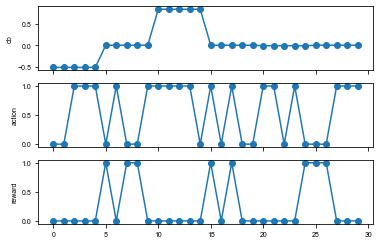

In [11]:
# Logging
log = {'ob': [], 'action': [], 'reward': []}

env = MyDecisionEnv(dt=100)
ob = env.reset()
log['ob'].append(ob)
for i in range(30):
    action = env.action_space.sample()  # A random agent
    ob, reward, done, info = env.step(action)
    
    log['action'].append(action)
    log['ob'].append(ob)
    log['reward'].append(reward)
    
log['ob'] = log['ob'][:-1]  # exclude last observation
# Visualize
f, axes = plt.subplots(3, 1, sharex=True)
for ax, key in zip(axes, ['ob', 'action', 'reward']):
    ax.plot(log[key], 'o-')
    ax.set_ylabel(key)

### Setting observation and ground-truth at the beginning of each trial

In many tasks, the observation and ground-truth are pre-determined for each trial, and can be set in ```self._new_trial()```. The generated observation and ground-truth can then be used as inputs and targets for supervised learning.

Observation and ground_truth can be set in ```self._new_trial()``` with the ```self.add_ob()``` and ```self.set_groundtruth``` methods. Users can specify the period and location of the observation using their names. For example, ```self.add_ob(1, period='stimulus', where='fixation')```.

This allows the users to access the observation and groundtruth of the entire trial with ```self.ob``` and ```self.gt```, and access their values with ```self.ob_now``` and ```self.gt_now```.


In [12]:
class MyDecisionEnv(TrialEnv):
    def __init__(self, dt=100, timing=None):
        super().__init__(dt=dt)  # dt is passed to base task
        
        # Setting default task timing
        self.timing = {'stimulus': 500, 'decision': 500}
        # Update timing if provided externally
        if timing:
            self.timing.update(timing)
        
        # Here we use ngym.spaces, which allows setting name of each dimension
        name = {'fixation': 0, 'stimulus': 1}
        self.observation_space = ngym.spaces.Box(
            low=-1., high=1., shape=(2,), name=name)
        name = {'fixation': 0, 'choice': [1, 2]}
        self.action_space = ngym.spaces.Discrete(3, name=name)

    def _new_trial(self):
        # Setting time periods for this trial
        periods = ['stimulus', 'decision']
        # Will add stimulus and decision periods sequentially using self.timing info
        self.add_period(periods)

        # Sample observation for the next trial
        stimulus = np.random.uniform(-1, 1, size=(1,))
        
        # Add value 1 to stimulus period at fixation location
        self.add_ob(1, period='stimulus', where='fixation')
        # Add value stimulus to stimulus period at stimulus location
        self.add_ob(stimulus, period='stimulus', where='stimulus')
        
        # Set ground_truth
        groundtruth = int(stimulus > 0)
        self.set_groundtruth(groundtruth, period='decision', where='choice')
        
        trial = dict()
        trial['stimulus'] = stimulus
        trial['ground_truth'] = groundtruth
        
        return trial
    
    def _step(self, action):
        # self.ob_now and self.gt_now correspond to
        # current step observation and groundtruth

        # If action equals to ground_truth, reward=1, otherwise 0
        reward = (action == self.gt_now) * 1.0
        
        done = False
        # By default, the trial is not ended
        info = {'new_trial': False}
        return self.ob_now, reward, done, info

Sampling one trial. The trial observation and ground-truth can be used for supervised learning.

In [13]:
env = MyDecisionEnv()
_ = env.reset()

trial = env.new_trial()
ob, gt = env.ob, env.gt

print('Trial information', trial)
print('Observation shape is (N_time, N_unit) =', ob.shape)
print('Groundtruth shape is (N_time,) =', gt.shape)

Trial information {'stimulus': array([0.36152289]), 'ground_truth': 1}
Observation shape is (N_time, N_unit) = (10, 2)
Groundtruth shape is (N_time,) = (10,)


Visualizing the environment with a helper function.

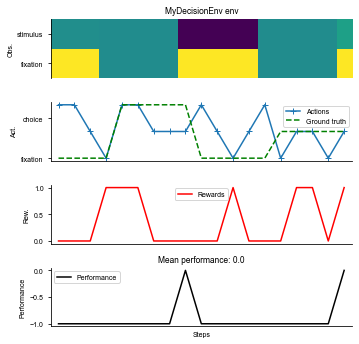

In [14]:
# Run the environment for 2 trials using a random agent.
fig = ngym.utils.plot_env(env, num_trials=2)

### An example perceptual decision-making task

Using the above style, we can define a simple perceptual decision-making task (the PerceptualDecisionMaking task from neurogym).

In [15]:
class PerceptualDecisionMaking(ngym.TrialEnv):
    """Two-alternative forced choice task in which the subject has to
    integrate two stimuli to decide which one is higher on average.

    Args:
        stim_scale: Controls the difficulty of the experiment. (def: 1., float)
        sigma: float, input noise level
        dim_ring: int, dimension of ring input and output
    """
    metadata = {
        'paper_link': 'https://www.jneurosci.org/content/12/12/4745',
        'paper_name': '''The analysis of visual motion: a comparison of
        neuronal and psychophysical performance''',
        'tags': ['perceptual', 'two-alternative', 'supervised']
    }

    def __init__(self, dt=100, rewards=None, timing=None, stim_scale=1.,
                 sigma=1.0, dim_ring=2):
        super().__init__(dt=dt)
        # The strength of evidence, modulated by stim_scale
        self.cohs = np.array([0, 6.4, 12.8, 25.6, 51.2]) * stim_scale
        self.sigma = sigma / np.sqrt(self.dt)  # Input noise

        # Rewards
        self.rewards = {'abort': -0.1, 'correct': +1., 'fail': 0.}
        if rewards:
            self.rewards.update(rewards)

        self.timing = {
            'fixation': 100,
            'stimulus': 2000,
            'delay': 0,
            'decision': 100}
        if timing:
            self.timing.update(timing)

        self.abort = False

        self.theta = np.linspace(0, 2*np.pi, dim_ring+1)[:-1]
        self.choices = np.arange(dim_ring)

        name = {'fixation': 0, 'stimulus': range(1, dim_ring+1)}
        self.observation_space = ngym.spaces.Box(
            -np.inf, np.inf, shape=(1+dim_ring,), dtype=np.float32, name=name)
        name = {'fixation': 0, 'choice': range(1, dim_ring+1)}
        self.action_space = ngym.spaces.Discrete(1+dim_ring, name=name)

    def _new_trial(self, **kwargs):
        # Trial info
        trial = {
            'ground_truth': self.rng.choice(self.choices),
            'coh': self.rng.choice(self.cohs),
        }
        trial.update(kwargs)

        coh = trial['coh']
        ground_truth = trial['ground_truth']
        stim_theta = self.theta[ground_truth]

        # Periods
        self.add_period(['fixation', 'stimulus', 'delay', 'decision'])

        # Observations
        self.add_ob(1, period=['fixation', 'stimulus', 'delay'], where='fixation')
        stim = np.cos(self.theta - stim_theta) * (coh/200) + 0.5
        self.add_ob(stim, 'stimulus', where='stimulus')
        self.add_randn(0, self.sigma, 'stimulus', where='stimulus')

        # Ground truth
        self.set_groundtruth(ground_truth, period='decision', where='choice')

        return trial

    def _step(self, action):
        new_trial = False
        # rewards
        reward = 0
        gt = self.gt_now
        # observations
        if self.in_period('fixation'):
            if action != 0:  # action = 0 means fixating
                new_trial = self.abort
                reward += self.rewards['abort']
        elif self.in_period('decision'):
            if action != 0:
                new_trial = True
                if action == gt:
                    reward += self.rewards['correct']
                    self.performance = 1
                else:
                    reward += self.rewards['fail']

        return self.ob_now, reward, False, {'new_trial': new_trial, 'gt': gt}

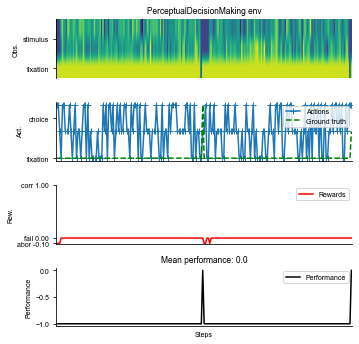

In [16]:
env = PerceptualDecisionMaking(dt=20)
fig = ngym.utils.plot_env(env, num_trials=2)